# Challenge: Create a Siamese Network with Custom Layers, Custom Losses, and Custom Outputs

Creating a Siamese Network using Keras to determine if two MNIST images are of the same digit involves several steps. A Siamese Network typically consists of two identical subnetworks with shared weights. The output is a measure of similarity between the inputs. For this task, we'll also add a custom layer and a custom loss function suitable for comparing similarity.

Here are the steps we'll follow:

1. Load the MNIST Dataset: We'll use the MNIST dataset available in Keras.

1. Define the Custom Layer: This could be a simple layer for demonstration purposes.

1. Define the Siamese Network Architecture: The architecture will consist of two identical subnetworks.

1. Implement a Custom Loss Function: Suitable for a Siamese network, typically a contrastive loss function.

1. Prepare the Data: Format the MNIST data for the Siamese network training.

1. Compile and Train the Model: Using the custom loss function.


Here is a nice image to represent a Siamese Network:


![](https://pyimagesearch.com/wp-content/uploads/2020/11/keras_siamese_networks_header.png)

The difference in our case is that we are not going to use a ConvNet but a normal Fully Connected network with a custom layer, and that at the end we are not going to apply the sigmoid loss so our output will be the euclidean distance between the images, a low value represents images being equal and a high value being different

In [1]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 1. Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


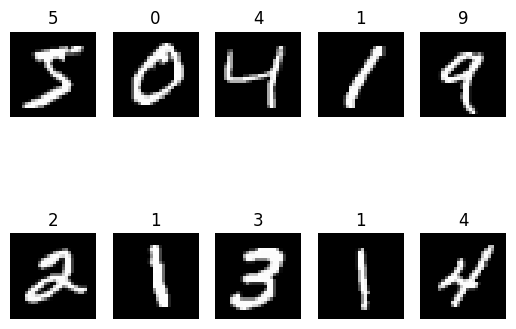

In [39]:
# Visualize 10 random images along with their labels
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')  # Hide the axes for a cleaner visualization
plt.show()  # Display the entire figure with all 10 images and their labels

In [40]:
print('train:',x_train.shape)
print('test:',x_test.shape)

train: (60000, 28, 28)
test: (10000, 28, 28)


### 2) Adding custom layer

In [42]:
# Define a custom layer by subclassing the `Layer` class from TensorFlow/Keras
class CustomLayer(Layer):
    def __init__(self, units=32, **kwargs):
        """
        Initialize the custom layer.

        Args:
            units (int): Number of units (neurons) in the layer. Default is 32.
            **kwargs: Additional keyword arguments passed to the parent class.
        """
        super(CustomLayer, self).__init__(**kwargs)  # Call the constructor of the parent class (Layer)
        self.units = units  # Store the number of units as an attribute

    def build(self, input_shape):
        """
        Create the weights of the layer.

        Args:
            input_shape: Shape of the input tensor to the layer.
        """
        # Define a trainable weight matrix with shape (input_dim, units), e.g., (3,4)*(4,2) -> (3,2),
        # 3 images with 4 features are multiplied by weight matrix of (4, 2) which results in (3,2)
        # as input for 2 units of current layer
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',  # Initialize weights randomly
                                 trainable=True)  # Make the weights trainable

    def call(self, inputs):
        """
        Perform the forward pass computation for the layer.

        Args:
            inputs: Input tensor to the layer.

        Returns:
            Output tensor after applying the layer's transformation.
        """
        # Perform matrix multiplication between inputs and weights
        return tf.matmul(inputs, self.w)

### 3) Create the base network

In [43]:
def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)                     # Flatten the input
    x = Dense(128, activation='relu')(x)    # Add a fully connected layer of 128 units
    x = CustomLayer(64)(x)                   # Create a custom layer with 64 units
    return Model(input, x)

In [44]:
# Get the shape of the input data (excluding the batch size)
input_shape = x_train.shape[1:]  # Shape of a single sample (e.g., (28, 28) for MNIST images)

# Create the base network (shared between both inputs)
base_network = build_base_network(input_shape)  # Build the base network (e.g., a CNN or MLP)

# Create the left input and connect it to the base network
input_a = Input(shape=input_shape)  # Define the left input tensor
processed_a = base_network(input_a)  # Pass the left input through the base network

# Create the right input and connect it to the base network
input_b = Input(shape=input_shape)
processed_b = base_network(input_b)

# Add a distance metric (e.g., Euclidean distance) between the two processed inputs
distance = Lambda(
    lambda embeddings: tf.sqrt(  # Compute the square root of the sum of squared differences
        tf.reduce_sum(  # Sum the squared differences along the specified axis
            tf.square(embeddings[0] - embeddings[1]),  # Compute the squared differences
            axis=1,  # Sum along the feature axis (e.g., for embeddings of shape (batch_size, embedding_dim))
            keepdims=True  # Keep the summed dimension as a single dimension (e.g., (batch_size, 1))
        )
    )
)([processed_a, processed_b])  # Pass the processed inputs (embeddings) to the Lambda layer

# Create the Siamese Network model
model = Model([input_a, input_b], distance)  # Define the model with two inputs and the distance as output

### 4) Add the custom loss function

In [45]:
def contrastive_loss(y_true, y_pred):
    """
    Compute the contrastive loss for a Siamese network.

    Args:
        y_true (tensor): Ground truth labels (1 for similar pairs, 0 for dissimilar pairs).
        y_pred (tensor): Predicted distances between the pairs.

    Returns:
        tensor: The computed contrastive loss.
    """
    margin = 1  # Define the margin for the contrastive loss

    # Cast y_true to float32 to ensure compatibility with TensorFlow operations
    y_true = tf.cast(y_true, tf.float32)

    # Square the predicted distances (y_pred)
    squared_pred = tf.square(y_pred)

    # Compute the squared hinge loss for dissimilar pairs
    # If y_pred > margin, the loss is 0; otherwise, it's (margin - y_pred)^2
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    # Compute the contrastive loss:
    # - For similar pairs (y_true = 1), use squared_pred (encourage small distances).
    # - For dissimilar pairs (y_true = 0), use margin_square (encourage distances > margin).
    loss = margin_square * (1 - y_true) + y_true * squared_pred

    # Return the mean loss over the batch
    return tf.reduce_mean(loss)

In [48]:
model.compile(optimizer='adam', loss=contrastive_loss)

In [49]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 64)             │        108,672 │ input_layer_10[0][0],  │
│                           │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │              0 │ functional_4[0][0],    │
│                           │                        │                │ functional_4[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 108,672 (424.50 KB)

 Trainable params: 108,672 (424.50 KB)

 Non-trainable params: 0 (0.00 B)

### 5) Create the paired train and test images

In [53]:
def create_pairs(x, digit_indices):
    """
    Create pairs of images and corresponding labels for training a Siamese network.

    Args:
        x (numpy array): The dataset containing images.
        digit_indices (list): A list of lists, where each sublist contains the indices of images for a specific digit (0-9).

    Returns:
        pairs (numpy array): An array of image pairs.
        labels (numpy array): An array of labels indicating whether the pairs are similar (1) or dissimilar (0).
    """
    pairs = []  # List to store the image pairs
    labels = []  # List to store the corresponding labels

    # Find the minimum number of samples for any digit (to ensure balanced pairs)
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    # Iterate over each digit (0-9)
    for d in range(10):
        # Iterate over the first n samples for the current digit
        for i in range(n):
            # Create a positive pair (two images of the same digit)
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]  # Add the positive pair to the list
            labels += [1]  # Label for positive pairs is 1 (similar)

            # Create a negative pair (two images of different digits)
            inc = random.randrange(1, 10)  # Randomly select a different digit
            dn = (d + inc) % 10  # Ensure the digit index wraps around if it exceeds 9
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]  # Add the negative pair to the list
            labels += [0]  # Label for negative pairs is 0 (dissimilar)

    # Convert the lists to numpy arrays and return them
    return np.array(pairs), np.array(labels)

In [54]:
digit_indices_train = [np.where(y_train == i)[0] for i in range(10)]
digit_indices_test = [np.where(y_test == i)[0] for i in range(10)]

In [56]:
digit_indices_train

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975]),
 array([    0,    11,    35, ..., 59968, 59993, 59997]),
 array([   13,    18,    32, ..., 59982, 59986, 59998]),
 array([   15,    29,    38, ..., 59963, 59977, 59988]),
 array([   17,    31,    41, ..., 59989, 59995, 59999]),
 array([    4,    19,    22, ..., 59973, 59990, 59992])]

In [59]:
train_pairs, train_labels = create_pairs(x_train, digit_indices_train)
test_pairs, test_labels = create_pairs(x_test, digit_indices_test)

In [58]:
train_pairs.shape, train_labels.shape

((108400, 2, 28, 28), (108400,))

In [60]:
model.fit([train_pairs[:, 0, :, :], train_pairs[:, 1, :, :]], train_labels, batch_size=128, epochs=10)

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1387
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0709
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0600
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0540
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0504
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0470
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0451
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0436
Epoch 9/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0420
Epoch 10/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0407


In [61]:
model.evaluate([test_pairs[:, 0, :, :], test_pairs[:, 1, :, :]], test_labels)

557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0426


0.05037562921643257

In [62]:
n = 10

sample_pairs = test_pairs[:n, :, :, :]  # take the first 10 pairs
sample_labels = test_labels[:n]

predictions = model.predict([sample_pairs[:, 0, :, :], sample_pairs[:, 1, :, :]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


In [63]:
print(f'Predictions: {predictions}')
print(f'Labels: {sample_labels}')

Predictions: [[0.05717292]
 [0.9056703 ]
 [0.03177738]
 [1.3878725 ]
 [0.08963111]
 [1.2261666 ]
 [0.10706487]
 [1.3669826 ]
 [0.10638668]
 [1.4240905 ]]
Labels: [1 0 1 0 1 0 1 0 1 0]
